In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import random
%matplotlib inline
import seaborn as sns; sns.set() # for plot styling
import numpy as np
import tarfile
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from skimage import io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import sys
sys.path.append('C:/Users/whitm/OneDrive/Documents/GitHub/usd-capstone/models/')
import resnet

## Load full data set

In [2]:
directory = "/Users/whitm/.fastai/data/food-101"
image_list = []
folder_names = []
# Get a list of all subdirectories in the given directory
subdirectories = [f.path for f in os.scandir(directory+ "/images") if f.is_dir()]

# Loop through each subdirectory
for subdirectory in subdirectories:
    # Get the folder name
    folder_name = os.path.basename(subdirectory)

    # Get a list of all image files within the subdirectory
    image_files = [f.path for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith(".jpg")]

    # Loop through each image file
    for image_file in image_files:
        # Append the image file to the image_list
        image_list.append(image_file)
        folder_names.append(folder_name)

In [3]:
len(image_list)

101000

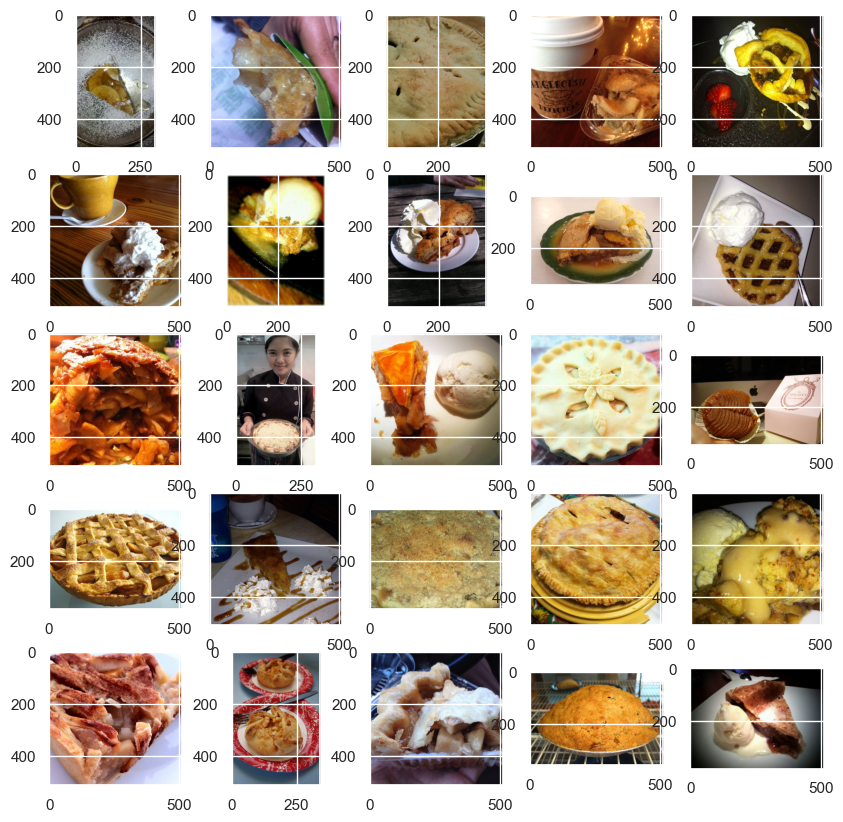

In [4]:
#plot the images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=image_list[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)

## Train // Test Split

In [5]:
paths_names = pd.DataFrame({"path":image_list, "category": folder_names})
len(paths_names)

101000

In [6]:
train, test = train_test_split(paths_names, train_size=0.8, stratify=paths_names['category'], random_state = 33)

In [7]:
print("Train Length:", len(train))
print("Test Length:", len(test))

Train Length: 80800
Test Length: 20200


In [8]:
train.head()

path           category
26665  /Users/whitm/.fastai/data/food-101/images\crab...         crab_cakes
54050  /Users/whitm/.fastai/data/food-101/images\hot_...  hot_and_sour_soup
74711  /Users/whitm/.fastai/data/food-101/images\peki...        peking_duck
57079  /Users/whitm/.fastai/data/food-101/images\humm...             hummus
40944  /Users/whitm/.fastai/data/food-101/images\fren...       french_fries

### Observe random images from different categories

In [10]:
for _, i in train.groupby('category').apply(lambda x: x.sample(1)).iterrows():
    print(i['path'])

/Users/whitm/.fastai/data/food-101/images\apple_pie\488508.jpg
/Users/whitm/.fastai/data/food-101/images\baby_back_ribs\1806940.jpg
/Users/whitm/.fastai/data/food-101/images\baklava\3850924.jpg
/Users/whitm/.fastai/data/food-101/images\beef_carpaccio\3561588.jpg
/Users/whitm/.fastai/data/food-101/images\beef_tartare\1473572.jpg
/Users/whitm/.fastai/data/food-101/images\beet_salad\220078.jpg
/Users/whitm/.fastai/data/food-101/images\beignets\717342.jpg
/Users/whitm/.fastai/data/food-101/images\bibimbap\2886796.jpg
/Users/whitm/.fastai/data/food-101/images\bread_pudding\3704457.jpg
/Users/whitm/.fastai/data/food-101/images\breakfast_burrito\92748.jpg
/Users/whitm/.fastai/data/food-101/images\bruschetta\1333827.jpg
/Users/whitm/.fastai/data/food-101/images\caesar_salad\3709161.jpg
/Users/whitm/.fastai/data/food-101/images\cannoli\2907043.jpg
/Users/whitm/.fastai/data/food-101/images\caprese_salad\2712857.jpg
/Users/whitm/.fastai/data/food-101/images\carrot_cake\1165793.jpg
/Users/whitm/.f

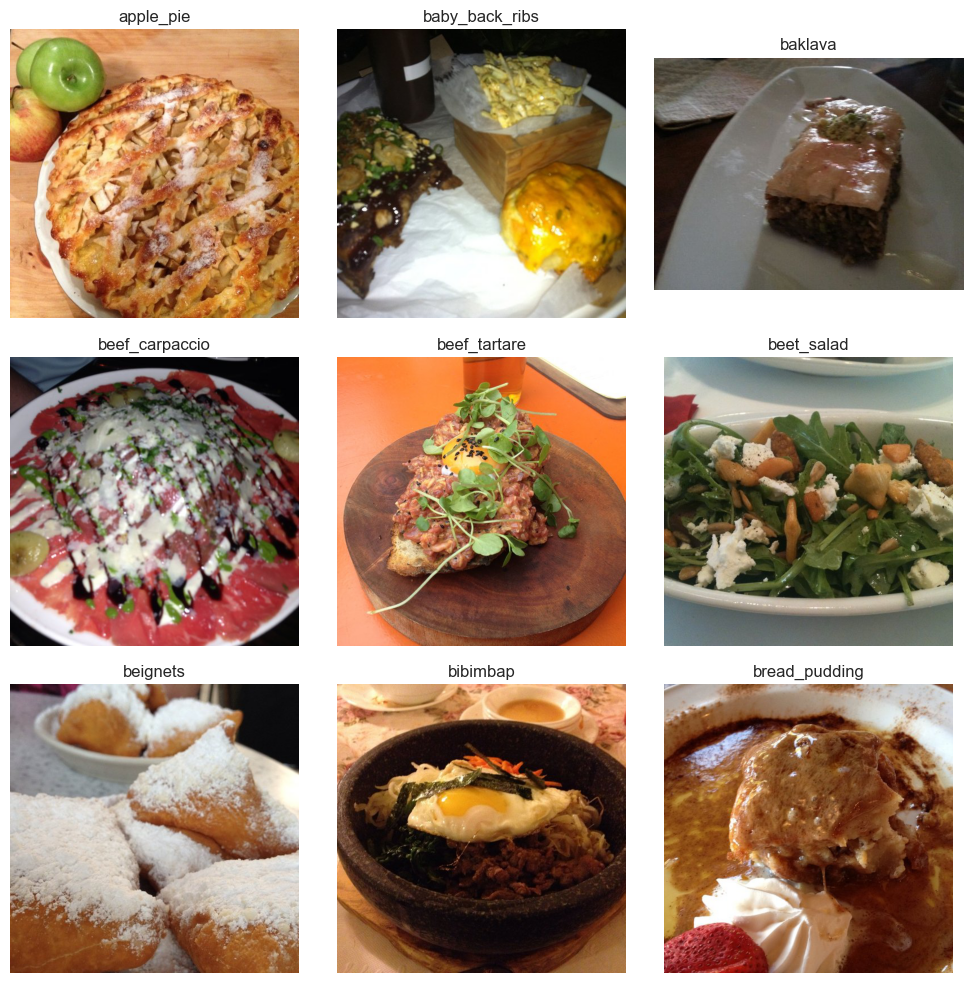

In [11]:
# Load a random sample of images from different categories
sample_images = train.groupby('category').apply(lambda x: x.sample(1))
sample_images_paths = []
for _, row in sample_images.iterrows():
    category = row['category']
    image_path = row['path']
    #image_path = f'{directory}/images/{category}/{filename}'
    sample_images_paths.append(image_path)

plt.figure(figsize=(10, 10))
num_images = min(len(sample_images_paths), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i, image_path in enumerate(sample_images_paths[:num_images]):
    plt.subplot(num_rows, num_cols, i+1)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(sample_images.iloc[i]['category'])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Observe images from apple pie category

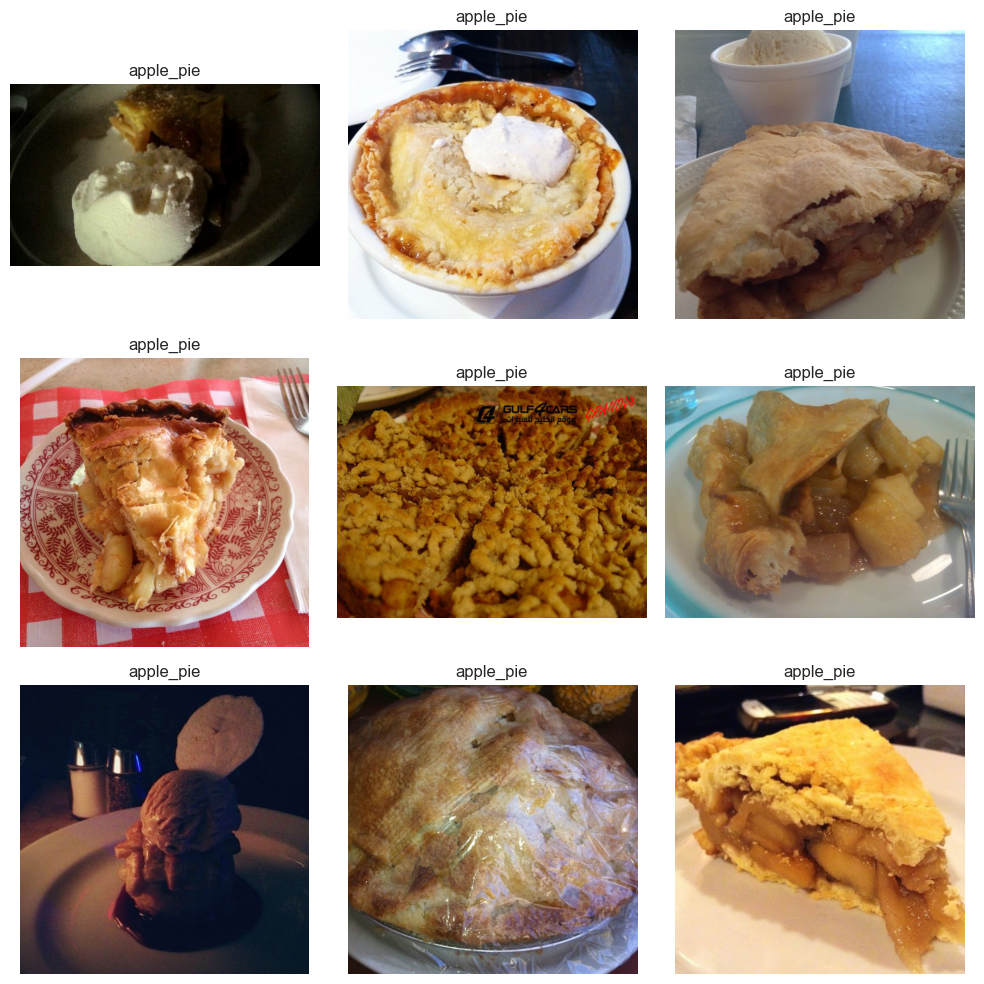

In [12]:
# Specify the category you want to plot
category_to_plot = "apple_pie"

# Filter the train_data based on the specified category
category_data = train[train['category'] == category_to_plot]

plt.figure(figsize=(10, 10))
num_images = min(len(category_data), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    image_path = category_data.iloc[i]['path']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(category_to_plot)
    plt.axis('off')
plt.tight_layout()
plt.show()

## EDA

### Explore the distribution of image size

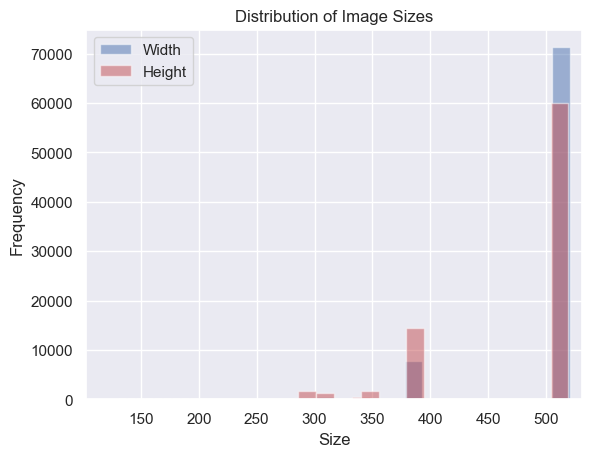

In [13]:
# Distribution of image sizes
image_sizes = []
for image_path in train['path']:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_sizes.append((width, height))
    
#plot the distribution
widths, heights = zip(*image_sizes)
plt.hist(widths, bins=50, alpha=0.5, color='b', label='Width', width=15)
plt.hist(heights, bins=50, alpha=0.5, color='r', label='Height', width=15)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()

 --> Most images have high values of height and width around 525 pixels, another size shows the next high frequency is around 375 pixels.

### Explore the distribution of mean intesity and contrast of the categories

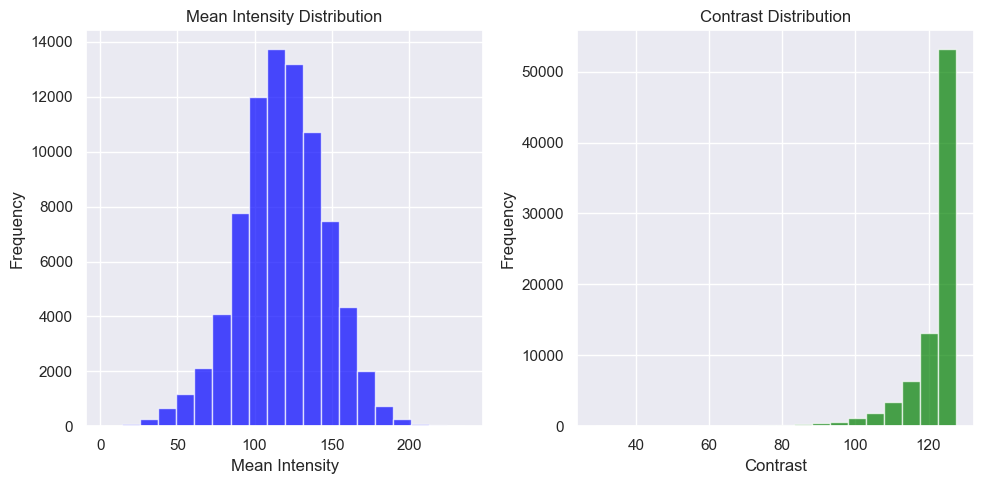

In [14]:
# Compute the mean intensity and contrast of images in the train_data dataset
mean_intensities = []
contrasts = []

for _, row in train.iterrows():
    image_path = row['path']
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the mean intensity
    mean_intensity = np.mean(gray)
    mean_intensities.append(mean_intensity)
    
    # Compute the contrast
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contrast = np.std(thresholded)
    contrasts.append(contrast)

# Plot the mean intensity and contrast
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=20, color='green', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

-->The mean intensity shows normal distribution of all images while contrast shows left skew distribution

### Explore the distribution of mean intesity and contrast values  for random 5 categories

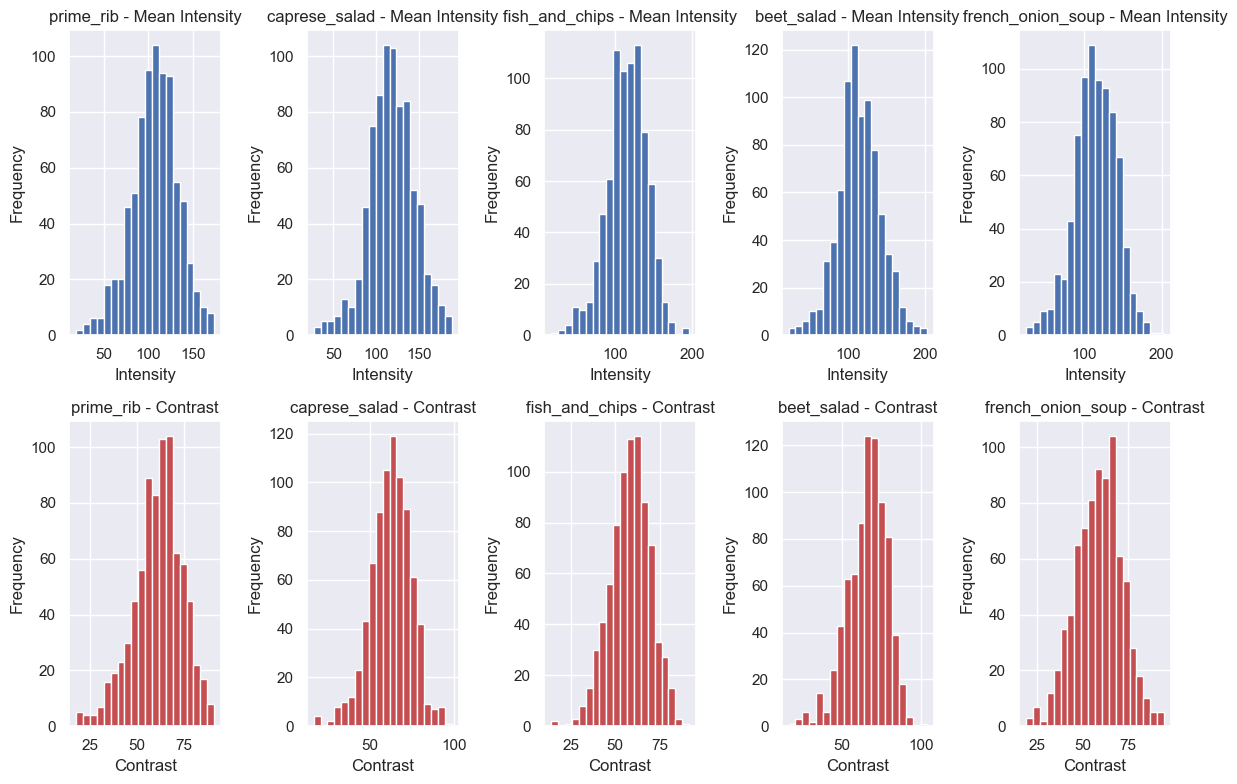

In [15]:
# Randomly select a subset of categories
num_categories = 5  
selected_categories = random.sample(labels, num_categories)

# Calculate and plot intensity and contrast for each category
plt.figure(figsize=(12, 8))
for i, category in enumerate(selected_categories):
    category_data = train[train['category'] == category]
    image_paths = category_data['path'].tolist()
    
    mean_intensities = []
    contrasts = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        intensity = np.mean(gray) 
        contrast = np.std(gray) 
        mean_intensities.append(intensity)
        contrasts.append(contrast)
        
    plt.subplot(2, num_categories, i + 1)
    plt.hist(mean_intensities, bins=20, color='b')
    plt.title(f'{category} - Mean Intensity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, num_categories, num_categories + i + 1)
    plt.hist(contrasts, bins=20, color='r')
    plt.title(f'{category} - Contrast')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

 --> The distribution of mean intensity and contrast in each category selected randomly show normal or close to normal ditribution. 

### Explore the texture of the images from each category

In [16]:
import mahotas.features.texture as texture
        
# Function to compute Haralick texture features for an image
def compute_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = texture.haralick(gray)
    features = haralick.mean(axis=0)
    return features

# Analyze texture features for each category
texture_features = []
for category in labels:
    category_data = train[train['category'] == category]
    image_paths = category_data['path'].tolist()
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        features = compute_haralick_features(image)
        texture_features.append(features)

In [17]:
texture_features[:5]

[array([ 2.27251333e-03,  3.07635366e+01,  9.95814211e-01,  3.67431964e+03,
         3.94909046e-01,  1.11782674e+02,  1.46665150e+04,  7.95808344e+00,
         1.06112610e+01,  6.79758918e-04,  3.09747636e+00, -4.80724093e-01,
         9.99343854e-01]),
 array([ 9.43849465e-04,  1.04702480e+02,  9.91193379e-01,  5.94642752e+03,
         3.14103474e-01,  3.16739700e+02,  2.36810076e+04,  8.64456541e+00,
         1.20029783e+01,  4.18382663e-04,  3.86048744e+00, -4.33352861e-01,
         9.99287761e-01]),
 array([ 7.55053021e-04,  3.06645758e+01,  9.91659391e-01,  1.83854640e+03,
         3.50513916e-01,  2.29684804e+02,  7.32352103e+03,  8.36092246e+00,
         1.13496460e+01,  5.81504336e-04,  3.23544983e+00, -4.59233162e-01,
         9.99356139e-01]),
 array([ 2.30069281e-04,  2.43026719e+02,  9.52853648e-01,  2.57741574e+03,
         2.03567896e-01,  2.73930298e+02,  1.00666362e+04,  8.62243368e+00,
         1.30248053e+01,  2.50714826e-04,  4.62530333e+00, -2.96022486e-01,
       

I ended up not getting this code segment to run. I think there must be a missing segment to create df_mean?

In [19]:
# Observe texture feature distibution for some categories 
num_categories_to_plot = 6 

plt.figure(figsize=(15, 10))

for i, category in enumerate(df_mean.index[:num_categories_to_plot]):
    plt.subplot(2, 3, i+1)
    plt.bar(df_mean.columns, df_mean.loc[category])
    plt.title(f'{category} - Average Texture Feature Values')
    plt.xlabel('Texture Features')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


TypeError: 'builtin_function_or_method' object is not subscriptable

<Figure size 1500x1000 with 0 Axes>

Prominent features in the plot are:

Haralick Texture Feature 4: Sum of Squares Variance - It captures the variance of pixel intensities in the image.
Haralick Texture Feature 7: Sum Variance - It captures the variance of the sum values of local image regions.

--> The first 6 categories plots indicate distinct patterns and textures in the image and highlight contrast and variations in intensity or brightness

### Load test data

In [20]:
test.head()

path       category
70111   /Users/whitm/.fastai/data/food-101/images\pad_...       pad_thai
82135   /Users/whitm/.fastai/data/food-101/images\ravi...        ravioli
100945  /Users/whitm/.fastai/data/food-101/images\waff...        waffles
29393   /Users/whitm/.fastai/data/food-101/images\cup_...      cup_cakes
88919   /Users/whitm/.fastai/data/food-101/images\seaw...  seaweed_salad

## Data Augmentation

In [118]:
cats = pd.DataFrame({'category':list(train['category'].unique())}).sort_values('category').reset_index(drop=True)
cats = cats.reset_index(drop=False)
food_cat_dict = pd.Series(cats.index, index=cats.category.values).to_dict()
# For modeling later, the values will need to be converted using this dict
food_cat_dict

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

### Sample Data Augmentation

In [92]:
image_size = 180

resize_rescale = tf.keras.Sequential([
  layers.Resizing(image_size, image_size),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.5),
])

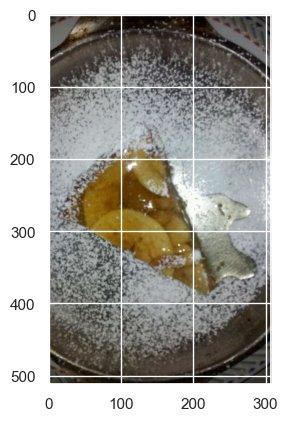

In [93]:
# Original Photo
image = cv2.imread(train['path'][0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)


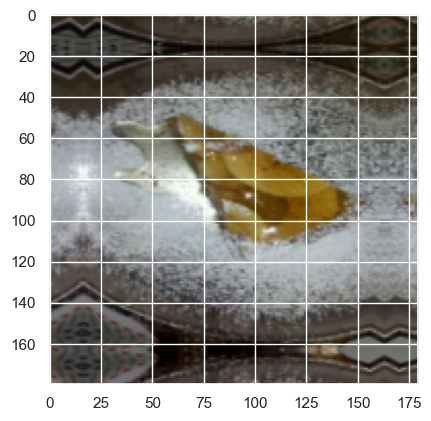

In [119]:
# Sample Augmentation
img = resize_rescale(image)
img = data_augmentation(img)
plt.imshow(img)